## Introduction to QML

Find me here: https://bit.ly/4ljT1im

In this tutorial we will

1. Discuss ML basics
2. Discuss QML basics and get familiar with Pennylane framework
3. Walk through a practical example of QML representation as Fourier functions



In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 39.7 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import StronglyEntanglingLayers

np.random.seed(0)

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


## Machine learning 101

### Creating the problem
Let's create a function (the ground truth) that we will learn with ML

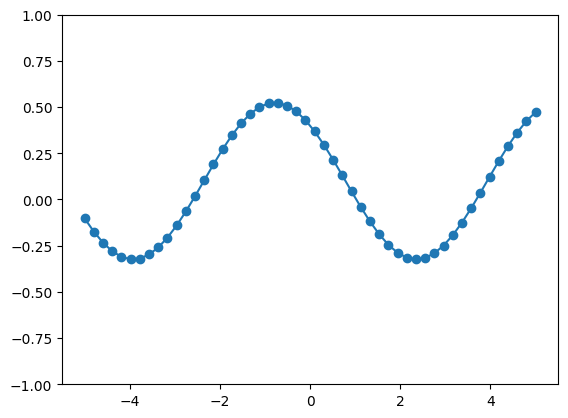

In [3]:
# degree of the target Fourier function
degree = 1

# coefficients of non-zero frequencies
coeffs = [0.15 + 0.15j] * degree

# coefficient of zero frequency
coeff0 = 0.1

def target_function(x):
    # This is a helper to create a function that the quantum
    # model has to fit using the Fourier series (the ground truth)
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128((idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

# And now to plot the target function
x = np.linspace(-5, 5, 50, requires_grad=False)
target_y = np.array([target_function(x_) for x_ in x], requires_grad=False)

plt.plot(x, target_y)
plt.scatter(x, target_y)
plt.ylim(-1, 1)
plt.show()

### Solving the problem

**Goal**: to approximate (aka learn) the underlying function that is generating your data

Cooking recepy:
1. Do a preliminary analysis of how complex your dataset is
2. Select your favourite learning algorithm (follow Occam's razor: take easiest model)
3. Train and test your algorithm on the data
4. Optimize hyperparameters if any
5. Check if performance is satisfactory, if not go back to step 2

##### Simple classical example
Let's use a polynomial regression $f = w_n x^n + ... + w_1 x + w_0$ of different degrees $n$ (hyperparameter) to fit the target function.

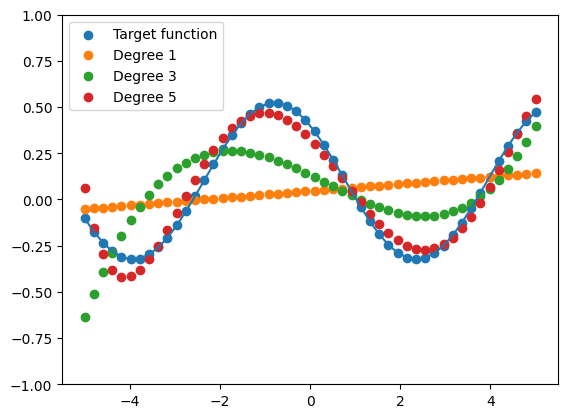

In [4]:
import numpy

plt.plot(x, target_y)
plt.scatter(x, target_y, label='Target function')
plt.scatter(x, numpy.poly1d(numpy.polyfit(x, target_y, 1))(x), label='Degree 1')
plt.scatter(x, numpy.poly1d(numpy.polyfit(x, target_y, 3))(x), label='Degree 3')
plt.scatter(x, numpy.poly1d(numpy.polyfit(x, target_y, 5))(x), label='Degree 5')
plt.ylim(-1, 1)
plt.legend()
plt.show()

## Quantum Machine Learning 101

Let's move on to quantum models. Luckily, thanks for a paper from Maria Schuld et al. [1], we know that a quantum model as such:

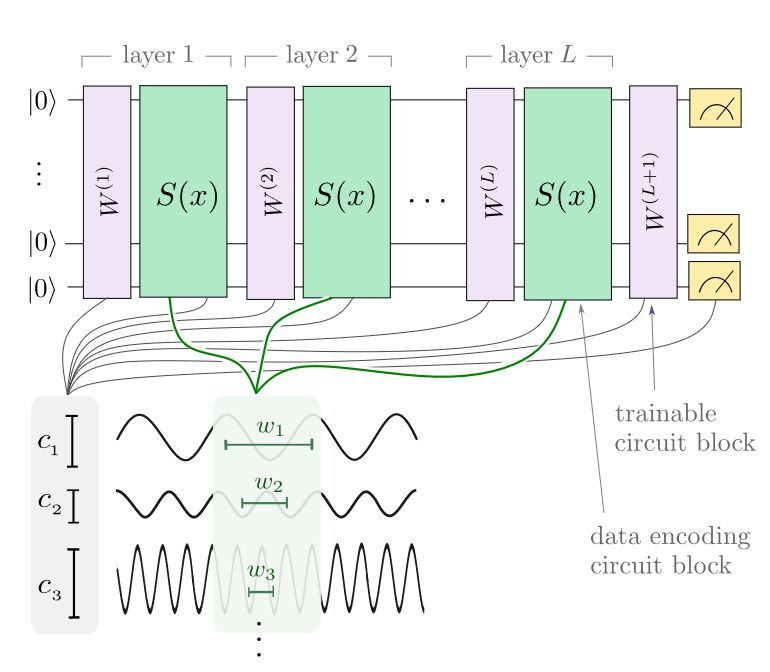

can be written as a Fourier-type sum of the form:

$f_θ(x)=\sum_{ω∈Ω}c_ω(θ)e^{iωx}$

The data encoding circuit blocks (denoted S(x)) determine the set Ω of available “frequencies”, and the remainder of the circuit, including the trainable parameters (denoted W(theta)), determines the coefficients $c_ω$.

### Let's get our hands dirty

We will have two quantum models.
The first and simpler quantum model is the following circuit:

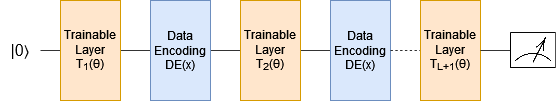

You can see the concept of data reuploading present in the circuit, considering the repetition of a data encoding layer after all trainable layers (apart from the last one).

In [13]:
# Now we define the quantum model that will learn the function we defined above

dev = qml.device('default.qubit', wires=1) # TODO: Instantiate the default qiskit device

def data_encoding_layer(x):
    # TODO: Define the data encoding as a parametrized RX gate
    qml.RX(x, wires=0)

def trainable_layer(theta):
    # TODO: Define the trainable layer as a general 3-parameters rotational gate
    qml.Rot(theta[0], theta[1], theta[2], wires=0)

@qml.qnode(dev)
def quantum_model(weights, x):
    # TODO: create the quantum model
    for w in weights[:-1]:
      trainable_layer(w)
      data_encoding_layer(x)
    trainable_layer(weights[-1])
    # TODO: return the expectation value
    # with respect to the Z observable
    return qml.expval(qml.PauliZ(0))


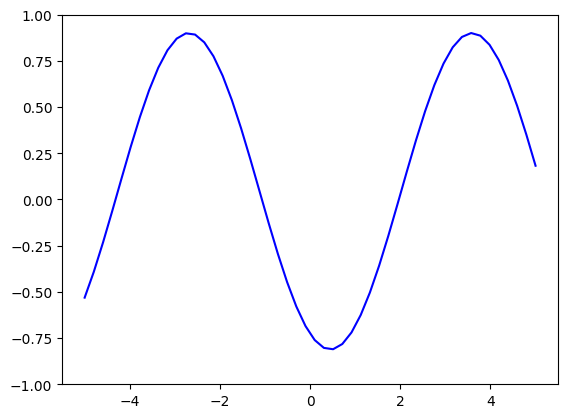

In [15]:
layers = 1
weights = 2 * np.pi * np.random.random(size=(layers+1, 3), requires_grad=True)

x = np.linspace(-5, 5, 50, requires_grad=False)
random_quantum_model_y = [quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

In [18]:
# TODO: print the circuit to check it is well defined - use qml.draw
print(qml.draw(quantum_model)(weights, x[0]))

0: ──Rot(3.57,0.12,3.88)──RX(-5.00)──Rot(3.85,3.88,5.93)─┤  <Z>


In [27]:
def square_loss(targets, preds):
    loss = 0
    # TODO: compute the square loss between the ground
    # truth values (targets) and what our model obtained (predictions)
    for i in range(len(targets)):
        loss += (targets[i] - preds[i])**2
    return loss / len(targets)

def cost(weights, x, y):
    preds = [quantum_model(weights, x_) for x_ in x]
    return square_loss(y, preds)

max_steps = 50
opt = qml.AdamOptimizer(0.05) ##choose learning rate correctly --> oscillations=maybe to high
batch_size = 20
cst = [cost(weights, x, target_y)]  # initial cost
for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.0008919604183050081
Cost at step  20: 0.00010420034322799823
Cost at step  30: 9.518239588679211e-05
Cost at step  40: 2.3278444755227418e-05
Cost at step  50: 1.9547783752885645e-05


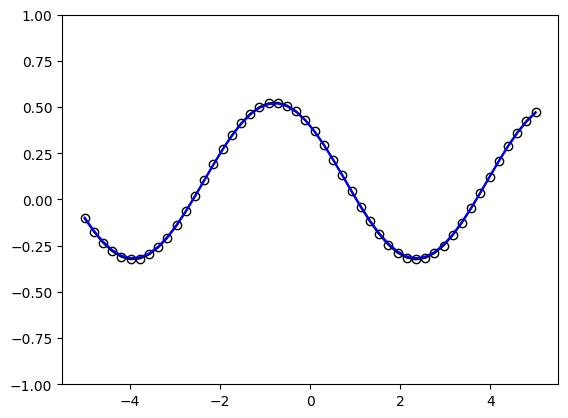

In [28]:
predictions = [quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show()

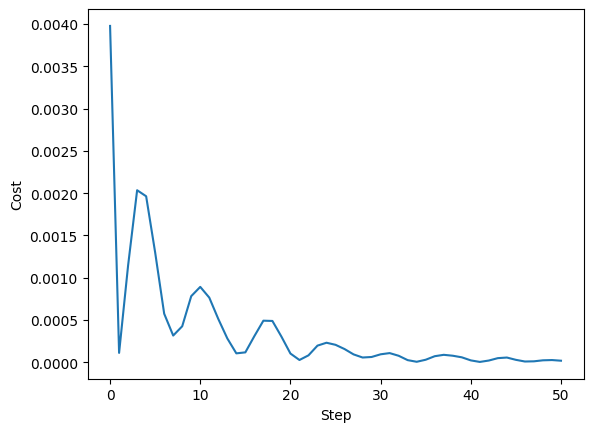

In [29]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.show()

### Let's make it more interesting
Now we will work on the same task using a more complex and parallel model.

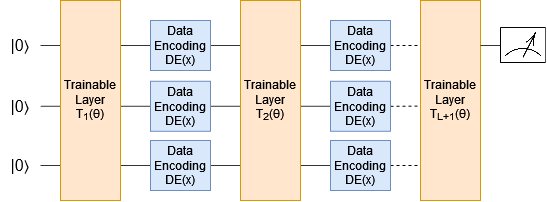



In [44]:
n_ansatz_layers = 2
n_qubits = 3

def data_encoding_layer(x):
    # TODO: apply an RX gate on each qubit
    qml.AngleEmbedding(features=[x] * n_qubits, wires=range(n_qubits), rotation="X")

def trainable_layer(theta):
    # TODO: apply pennylane's strongly entangling layer
    qml.StronglyEntanglingLayers(weights=theta, wires=range(n_qubits))

# TODO: Instantiate the qiskit default device
dev = qml.device('default.qubit', wires=3)
@qml.qnode(dev)
def parallel_quantum_model(weights, x):

    trainable_layer(weights[0])
    data_encoding_layer(x)
    trainable_layer(weights[1])

    # TODO: measure the expectation value of the
    # Z measurement of the first qubit
    return qml.expval(qml.PauliZ(0))

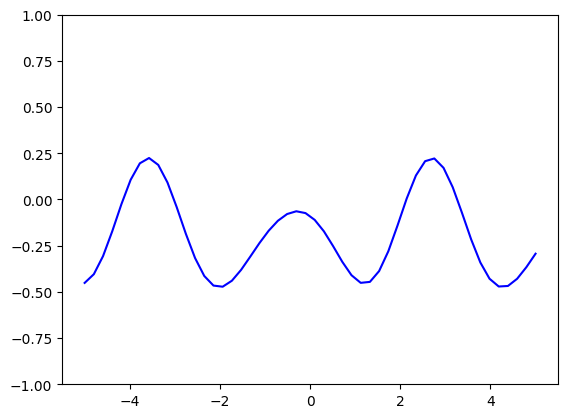

In [45]:
trainable_block_layers = 2
weights = 2 * np.pi * np.random.random(size=(2, trainable_block_layers, n_qubits, 3), requires_grad=True)

x = np.linspace(-5, 5, 50, requires_grad=False)
random_quantum_model_y = [parallel_quantum_model(weights, x_) for x_ in x]

# We can plot to see how the function currently looks like
plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

Cost at step  10: 0.021400533778465052
Cost at step  20: 0.010141490808391189
Cost at step  30: 0.0023848526915941303
Cost at step  40: 0.001526971537641694
Cost at step  50: 0.0014008893353290718


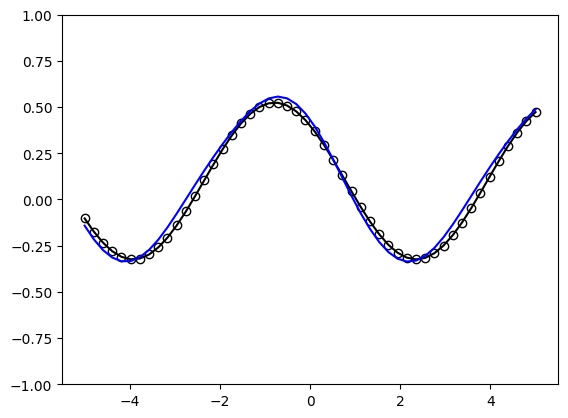

In [46]:
# We need to reach the same target function as before
def cost(weights, x, y):
    predictions = [parallel_quantum_model(weights, x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 20
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

predictions = [parallel_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show()

## takes long even on small data --> typical for QML

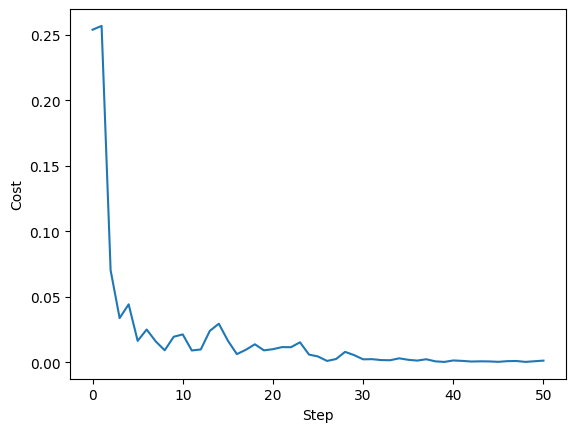

In [47]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.show()

Tutorial based on:

[1] "The effect of data encoding on the expressive power of variational quantum machine learning models" by Schuld, Sweke, and Meyer https://arxiv.org/abs/2008.08605

